# Particulate Matter

Another way to measure the overall health and wellness of a specific area is air quality, especially in Pittsburgh. With a history of steel production brining much pollution into the air a key aspect of finding the best neighborhood is which ones have the least particulate matter in the air.

Data Set Used: [Allegheny County Particulate Matter](https://data.wprdc.org/dataset/particulate-matter-2-5)

This dataset is provided by the EPA.

In [141]:
# Imports needed
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv("pm2.52011ct.csv")

# Show the first 5 rows of the dataframe
df.head(5)

,CensusTract,PM25
0,10300,12.264655
1,20100,12.283052
2,20300,12.241216
3,30500,12.234197
4,40200,12.315312


## Step 1: Adding In Census Info & Merging

I read the census tract values here and merge them with the `CensusTract` values within the dataset of the particulate matter values.

In [142]:
# Load the census tract data with latitude and longitude
tracts_df = pd.read_csv("Allegheny_County_Census_Tracts_2020.csv")

# Adjusting the CensusTract formatting to only include the last 6 digits
df['CensusTract'] = df['CensusTract'].astype(str).str.zfill(6)
tracts_df['CensusTract'] = tracts_df['GEOID'].astype(str).str[-6:]

# Merging on the adjusted CensusTract
merged_df = pd.merge(df, tracts_df, on='CensusTract')

# Display the first 5 rows of the merged dataframe
merged_df.head(5)

,CensusTract,PM25,FID,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape__Area,Shape__Length
0,020100,12.283052,190,42,3,20100,42003020100,1400000US42003020100,201.0,Census Tract 201,G5020,S,1427891,465722,40.440662,-80.001277,2.038098e+07,20399.907349
1,020300,12.241216,201,42,3,20300,42003020300,1400000US42003020300,203.0,Census Tract 203,G5020,S,1590870,326538,40.454500,-79.981276,2.063713e+07,24574.104834
2,030500,12.234197,270,42,3,30500,42003030500,1400000US42003030500,305.0,Census Tract 305,G5020,S,927620,0,40.442113,-79.985307,9.983961e+06,14774.816642
3,040200,12.315312,271,42,3,40200,42003040200,1400000US42003040200,402.0,Census Tract 402,G5020,S,604860,0,40.440110,-79.966247,6.510111e+06,16507.286891
4,040400,12.245356,324,42,3,40400,42003040400,1400000US42003040400,404.0,Census Tract 404,G5020,S,194956,0,40.447362,-79.949426,2.098310e+06,6592.966427


## Step 2: Creating GeoDataFrame & Loading Neighborhood Data

Here I preform the same exact process as I did in the mortality indicators analysis. In order to map the `CensusTract` values to actual neighborhoods in Pittsburgh I had to create a GeoDataFrame, as I am using longitude and latitude values. I also needed the data of the neighborhoods in Pittsburgh to define thier locations for mapping of the `CensusTract` values.

In [143]:
# Create a GeoDataFrame using latitude and longitude
merged_df['geometry'] = merged_df.apply(lambda row: Point(float(row['INTPTLON']), float(row['INTPTLAT'])), axis=1)
gdf_df = gpd.GeoDataFrame(merged_df, geometry='geometry')

# Set the initial CRS (assuming WGS 84)
gdf_df.set_crs(epsg=4326, inplace=True)

# Load neighborhoods shapefile
neighborhoods_gdf = gpd.read_file('neighborhoods/Neighborhoods_.shp')

## Step 3: Match Checking & Joining

Once again, this is the same process I used when creating the visualizations for the mortality indicators. Here is where I had to check that the location values for the tracts and neighborhoods actually lined up. Once that was all good, I then used a spatial join to combine the location of the neighborhoods with the census tracts.

In [144]:
# Ensure CRS matches between the two GeoDataFrames
if gdf_df.crs != neighborhoods_gdf.crs:
    gdf_df.to_crs(neighborhoods_gdf.crs, inplace=True)

# Perform spatial join
joined_gdf = gpd.sjoin(gdf_df, neighborhoods_gdf, how='left', predicate='within')

## Step 4: Ordering & Plotting

The data within the particulate matter dataset was very simple, they were not even any NaN/null values.  All I did here was group them by neighborhood and take the mean of each of thier particulate matter. I then ordered the bottom 50 neighborhoods, with the least particulate matter in ascending order. I did end up editing the y axis a lot because the change in particulate matter would not be as easy to see if it were 0 to 12.5.

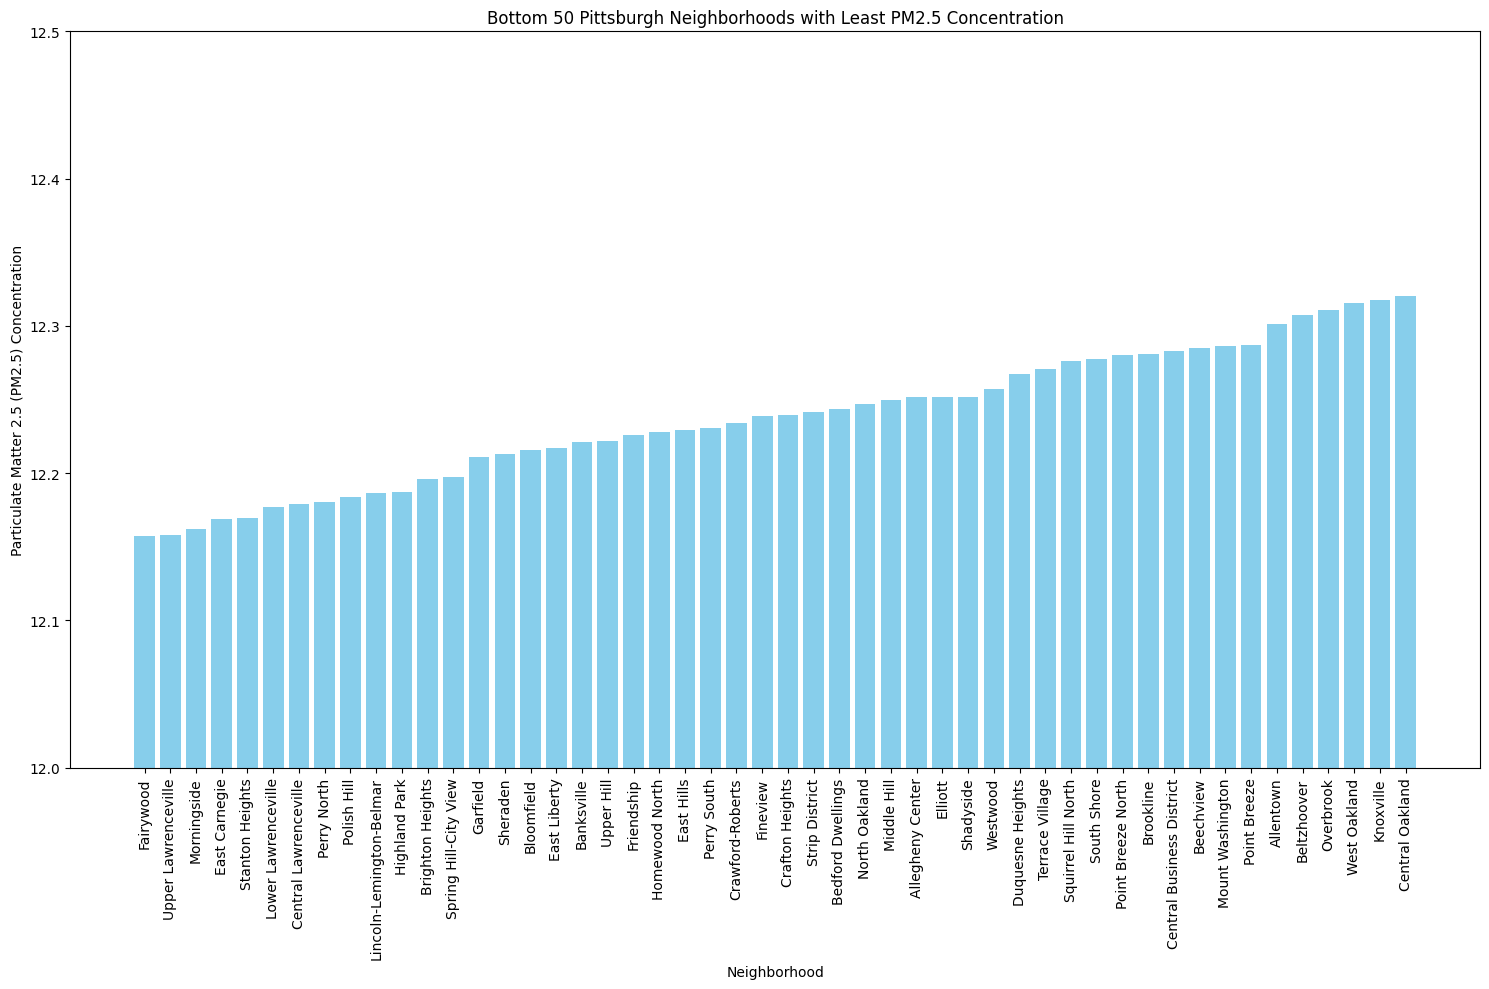

In [145]:
# Group by neighborhood and calculate the mean PM2.5 for each neighborhood
neighborhood_pm25 = joined_gdf.groupby('hood')['PM25'].mean().reset_index()

# Sort the neighborhoods by PM2.5 in ascending order and select the bottom 50
bottom_50_neighborhoods = neighborhood_pm25.nsmallest(50, 'PM25')

# Plot the bar graph
plt.figure(figsize=(15, 10))
plt.bar(bottom_50_neighborhoods['hood'], bottom_50_neighborhoods['PM25'], color='skyblue')
plt.xlabel('Neighborhood')
plt.ylabel('Particulate Matter 2.5 (PM2.5) Concentration')
plt.title('Bottom 50 Pittsburgh Neighborhoods with Least PM2.5 Concentration')
plt.xticks(rotation=90)
plt.ylim(12, 12.5)  # Set the y-axis limits from 11 to 13
plt.tight_layout()
plt.show()

## Step 5: Mapping the Data Geographically

Just like with the mortality data, I wanted to include another graph to have a more geographic representation of the data.  I loaded a shapefile into the program and then matched the `CensusTract` in the `pm2.52011ct.csv` with the `GEOID` in the `Allegheny_County_Census_Tracts_2020.shp`. I then merged the dataframe and shapefiles and filtered the results for what I desired as above.  Finally, I created a heatmap for a more geographically-oriented approach of the data.

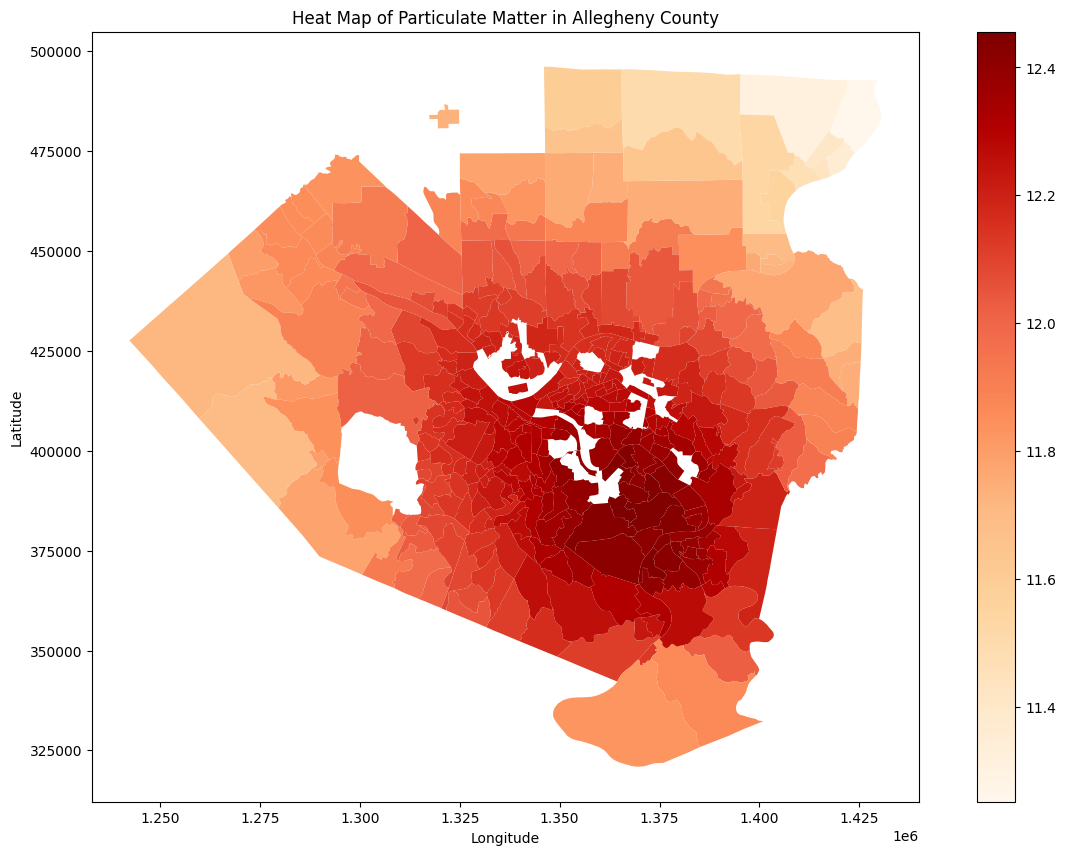

In [146]:
# Load the shapefile
shapefile_path = 'Allegheny_County_Census_Tracts_2020/Allegheny_County_Census_Tracts_2020.shp'
gdf = gpd.read_file(shapefile_path)

# Reset index to access 'Census_Tract' column
df.reset_index(inplace=True)

# Adjust CensusTract formatting to only include the last 6 digits
df['CensusTract'] = df['CensusTract'].astype(str).str[-6:]
gdf['CensusTract'] = gdf['GEOID'].astype(str).str[-6:]

# Merge GeoDataFrame with the DataFrame on 'CensusTract'
merged_gdf = gpd.GeoDataFrame(pd.merge(gdf, df, on='CensusTract'))

# Plot the heat map for the PM2.5 column
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_gdf.plot(column='PM25', cmap='OrRd', linewidth=0.8, ax=ax, legend=True)

# Add labels and title
plt.title('Heat Map of Particulate Matter in Allegheny County')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Conclusion: Neighborhoods With the Lowest Particulate Matter

According to the dataset & graph, the top ten best neighborhoods with the lowest particulate matter are as follows:

1. Fairywood
1. Upper Lawrenceville
1. Morningside
1. East Carnegie
1. Stanton Heights
1. Lower Lawrence
1. Central Lawrenceville
1. Perry North
1. Polish Hill
1. Lincoln-Lemington-Belmar
